In [1]:
import pandas as pd
import pydicom as dicom
from PIL import Image
import numpy as np
import os
import cv2
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt

In [22]:
def get_patient_dictionary(path_to_patient_folder):
    """
    
    Returns dict of different types of images in the folder of patient. 
    
    Returns:
        dict: key - type of images; value - list of DICOM files, which sorted in the ascending order with restepct to the
                    depth of the image slice.
    """
    patient_dict = {}
    
    dicom_file_names = os.listdir(path_to_patient_folder)
    
    for i in range(len(dicom_file_names)):
        cur_dicom_obj = dicom.dcmread(os.path.join(path_to_patient_folder, dicom_file_names[i]))
        
        if cur_dicom_obj.SeriesDescription not in patient_dict.keys():
            patient_dict[cur_dicom_obj.SeriesDescription] = []
        patient_dict[cur_dicom_obj.SeriesDescription].append(cur_dicom_obj)
        
    # sort each type of images with respect to their depth in ascending order
    for i in patient_dict:
        patient_dict[i].sort(key=lambda x: x.InstanceNumber)
    
    return patient_dict

def get_pixels_hu(list_of_imgs):
    """
    Convert stack of the images into Houndsfeld units
    """
    image = np.stack([s.pixel_array for s in list_of_imgs])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = list_of_imgs[0].RescaleIntercept
    slope = list_of_imgs[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

def show_stack(list_of_imgs, rows=6, cols=6, start_with=10, show_every=3):
    """
    Show stack of the images with the given parameters.
    """
    fig,ax = plt.subplots(rows,cols,figsize=[20,20])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(list_of_imgs[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()





### Read One Patient

In [23]:
path_to_the_patient = r'..\dataset\ctca_with_recons_excel_reports_321-350\321_CTCADOP23111947\images'


pat_dict = get_patient_dictionary(path_to_the_patient)

### Print all keys in the current patient

In [4]:
for key in pat_dict:
    print(key)

LCX-OM*
RCA-AM*
RCA-PDA*
RCA-PLB*
AW electronic film
Scout
CALCIUM SCORE
CTCA SMARTPHASE
LAD*
LAD-D1*
LAD-D2*
LCX*


### Example of getting the image

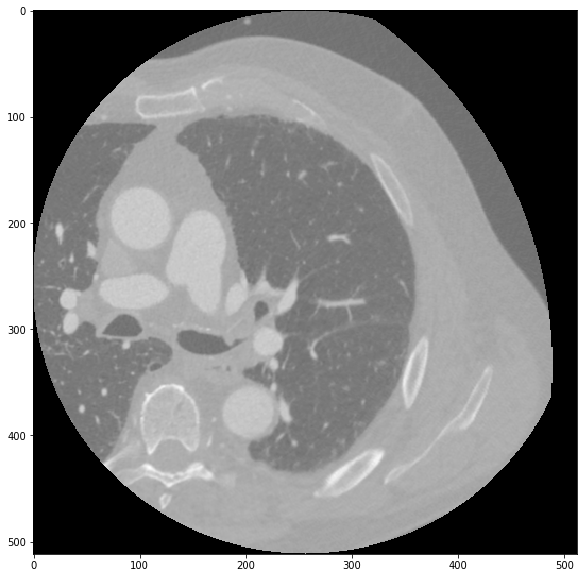

In [5]:
dicom_file = pat_dict['CTCA SMARTPHASE'][10]# we take DICOM file of the 10th slice in calcium score section
img = dicom_file.pixel_array

plt.figure(figsize=(10,10))
plt.imshow(img, 'gray')

### Convert to Hounsfield Units

The unit of measurement in CT scans is the Hounsfield Unit (HU), which is a measure of radiodensity. CT scanners are carefully calibrated to accurately measure this. By <b>default</b> the returned values are not in this unit.  We convert to the HU range by multiplying with the rescale slope and adding the intercept (which are conveniently stored in the metadata of the scans!)
![title](hu_range.png)


In [6]:
converted_to_hu_images = get_pixels_hu(pat_dict['CTCA SMARTPHASE'])

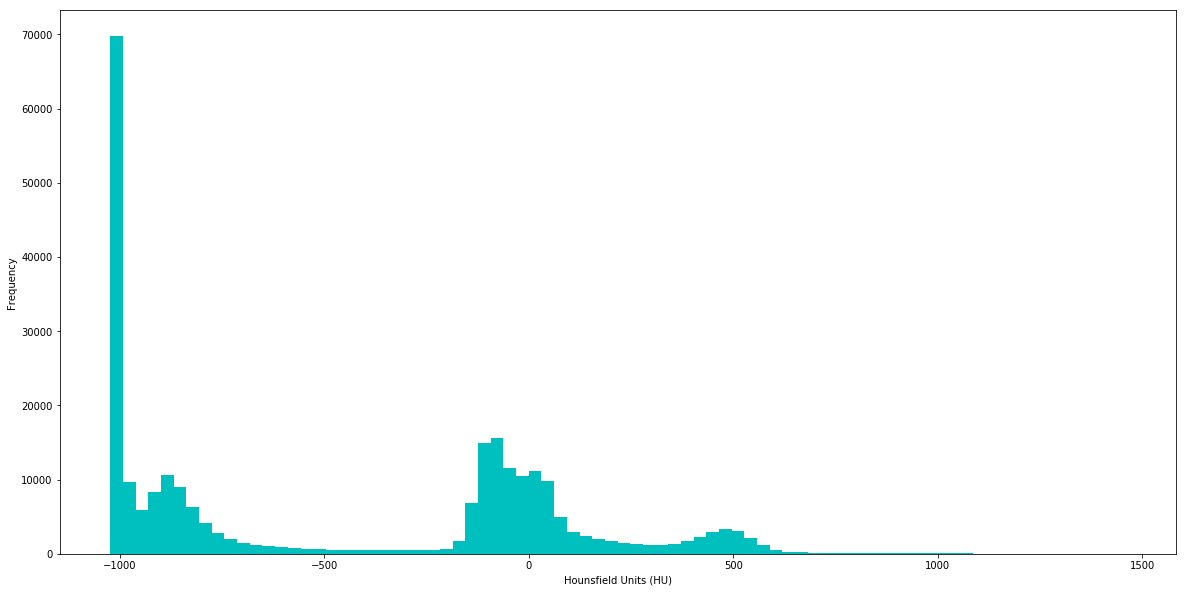

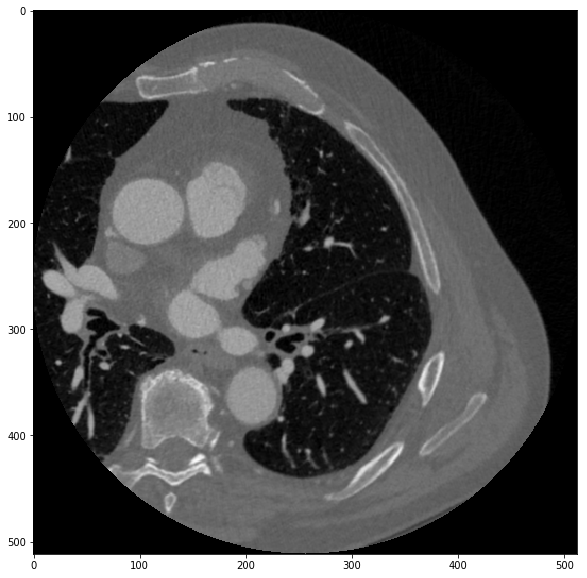

In [7]:
plt.figure(figsize=(20,10))
plt.hist(converted_to_hu_images[50].flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")

plt.figure(figsize=(10,10))
plt.imshow(converted_to_hu_images[50], 'gray')

### Show stack of the images(RCA-PDA)

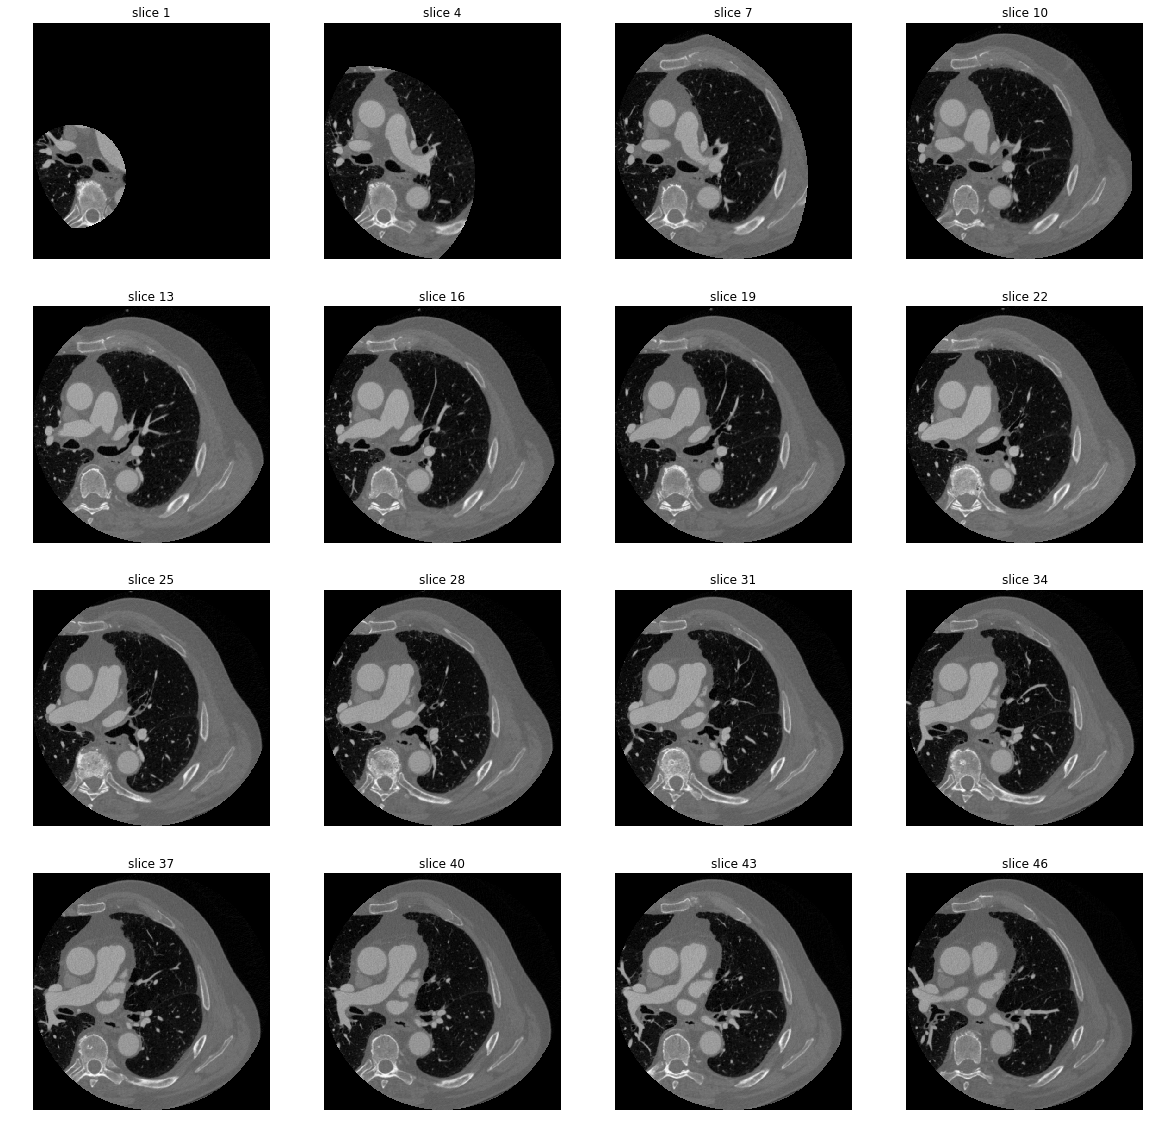

In [10]:
show_stack(converted_to_hu_images, rows=4, cols=4, start_with=1, show_every=3)

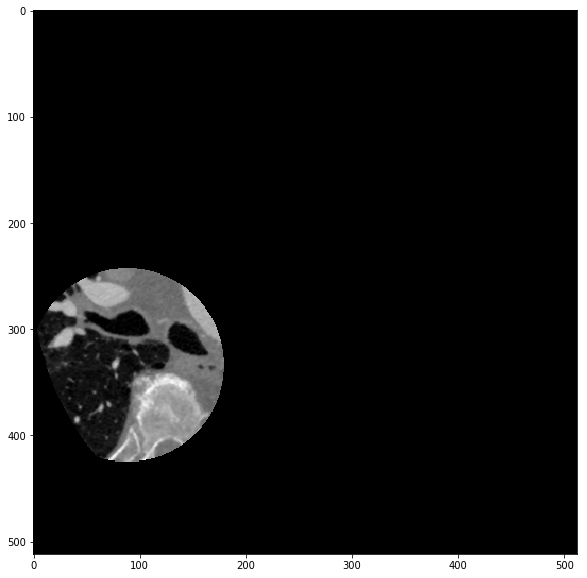

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(converted_to_hu_images[0], 'gray')

### Number of Images over all patients with the records and MPR reconstruction

In [20]:
path_to_the_patients = r"..\dataset\ctca_with_recons_excel_reports_321-350"

patients_folder_names = os.listdir(path_to_the_patients)

In [38]:
dict_with_types_of_images = dict()

for i in tqdm(range(len(patients_folder_names))):
    cur_pat_dict = get_patient_dictionary(os.path.join(path_to_the_patients, patients_folder_names[i], 'images'))
    for key in cur_pat_dict:
        if key not in dict_with_types_of_images.keys():
            dict_with_types_of_images[key] = 0
        dict_with_types_of_images[key]+= len(cur_pat_dict[key])


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [05:28<00:00, 11.59s/it]


In [40]:
for key in dict_with_types_of_images:
    print(key, dict_with_types_of_images[key])

LCX-OM* 150
RCA-AM* 50
RCA-PDA* 100
RCA-PLB* 100
AW electronic film 52
Scout 10
CALCIUM SCORE 1712
CTCA SMARTPHASE 4320
LAD* 150
LAD-D1* 100
LAD-D2* 150
LCX* 150
LAD 1200
LAD - D1 50
LCX 1050
LCX-OM 800
LCX-OM2 600
RCA-PDA 798
RCA-PLB 750
LAD-D1 950
RIB 200
SS-Freeze 39% - Original Series 306 256
RCA-AM 150
LAD-D2 550
RCA-PDA2 250
RCA-PLB2 100
SS-Freeze 75% - Original Series 305 768
RCA-PDA2* 50
CTCA 992
Auto State - series 405 - 256 images 1
LCX-PLB 150
RCA 200
OM 150
LCX-PDA 150
LAD-D3 150
LCX-OM1 50
LCX-OM3 200
LCX-PLB1 50
PDA 300
PLB 250
PDA2 100
33 256
PLB2 50
LCX-OM2* 50
LCX-OM3* 50
PDA* 50
PLB* 50
Auto State - series 3 - 256 images 1
CTCA 70% 256
Auto State - series 306 - 256 images 1
OM2 50
Auto State - series 301 - 256 images 2
3D Saved State -  FINAL 76% 1
